In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchsummary import summary
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
import time
import pathlib
import os
import scipy.io
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import glob
import h5py

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# MRI Data set


In [15]:
class BrainTumorDataset(Dataset):
    def __init__(self, mat_files, transform=None):
        self.mat_files = mat_files
        self.transform = transform

    def __len__(self):
        return len(self.mat_files)

    def __getitem__(self, idx):
        with h5py.File(self.mat_files[idx], "r") as f:
            image = f["cjdata"]["image"][()]

            label = int(
                f["cjdata"]["label"][0][0] - 1
            )  # Convert labels from 1-3 to 0-2

            # Convert to grayscale ('L' mode) before applying transformations
            image = Image.fromarray(image).convert("L")
            if self.transform:
                image = self.transform(image)

        return image, label


# Sample use:
# Assuming path to .mat files is './data/New folder/'
mat_files = [
    os.path.join("./data/New folder/", f)
    for f in os.listdir("./data/New folder/")
    if f.endswith(".mat")
]

# Split the data into train and test sets (e.g., 80% train, 20% test)
indices = list(range(len(mat_files)))
split = int(np.floor(0.7 * len(mat_files)))
np.random.shuffle(indices)
train_indices, test_indices = indices[:split], indices[split:]


# Transforms
transforming_img = transforms.Compose(
    [
        transforms.Resize((227, 227)),
        transforms.ToTensor(),
    ]
)

from torch.utils.data import Subset

train_set_MRI = Subset(
    BrainTumorDataset(mat_files, transform=transforming_img), train_indices
)

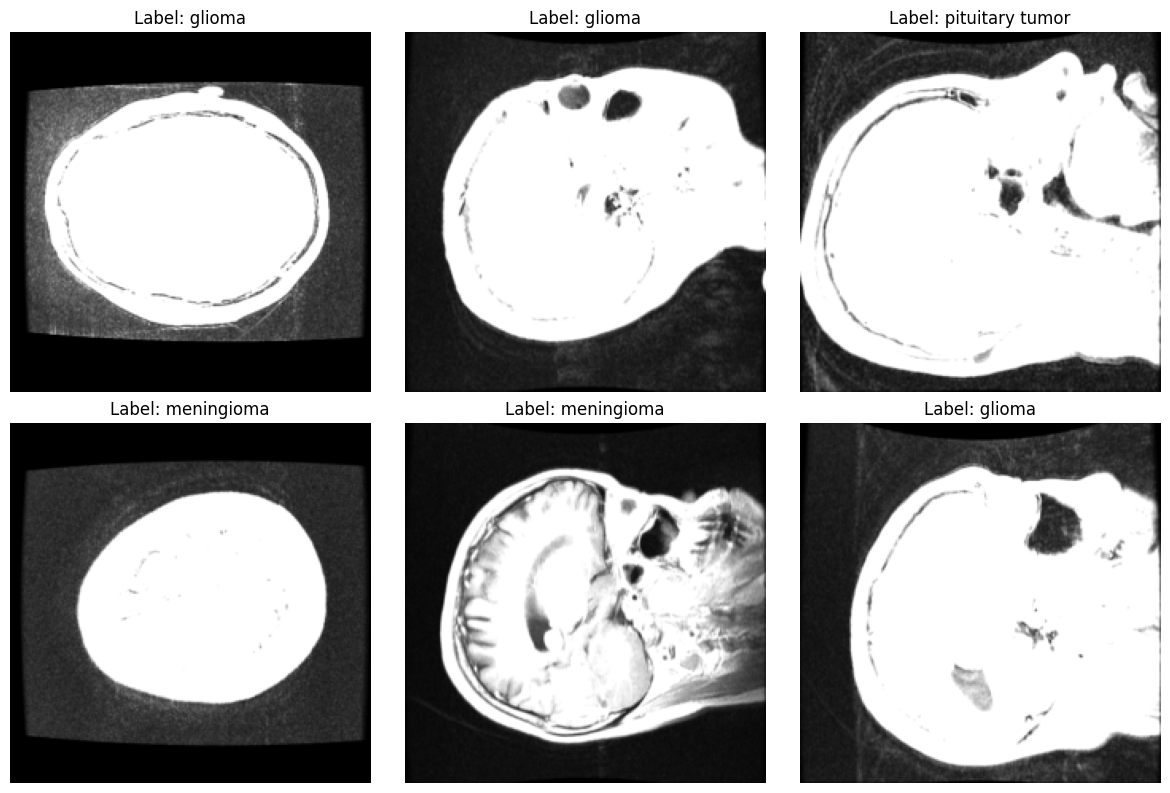

In [133]:
# Define the function to plot samples from the dataset
def plot_samples(dataset, num_samples=6):
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    tumor_types = {0: "meningioma", 1: "glioma", 2: "pituitary tumor"}

    for i in range(2):
        for j in range(3):
            idx = np.random.randint(0, len(dataset))
            image, label = dataset[idx]

            # Convert PyTorch tensor to numpy array and display the image
            axs[i, j].imshow(image.squeeze().numpy(), cmap="gray")
            axs[i, j].set_title(f"Label: {tumor_types[label]}")
            axs[i, j].axis("off")

    # Create a fake image that will not be shown (for the sake of legend)
    for label, tumor in tumor_types.items():
        axs[0, 0].plot([], label=f"{label}: {tumor}", color="white")

    plt.tight_layout()
    plt.savefig("MRIData.pdf")
    plt.show()


# Plot samples from the train_set_MRI dataset
plot_samples(train_set_MRI)

In [16]:
# Initializing variables to store sum and squared sum
total_sum = 0
total_squared_sum = 0
num_pixels = 0

# Calculating mean and standard deviation
for data, _ in train_set_MRI:
    total_sum += data.sum()
    total_squared_sum += (data**2).sum()
    num_pixels += data.numel()

mean = total_sum / num_pixels
std_dev = (total_squared_sum / num_pixels - mean**2) ** 0.5

print(f"Mean: {mean.item()}")
print(f"Standard Deviation: {std_dev.item()}")

Mean: 0.5666518807411194
Standard Deviation: 0.4237934947013855


In [17]:
# Transforms
transforming_img = transforms.Compose(
    [
        transforms.Resize((227, 227)),
        transforms.ToTensor(),
        transforms.Normalize((mean.item()), (std_dev.item())),
    ]
)

from torch.utils.data import Subset

train_set_MRI = Subset(
    BrainTumorDataset(mat_files, transform=transforming_img), train_indices
)
test_set_MRI = Subset(
    BrainTumorDataset(mat_files, transform=transforming_img), test_indices
)
train_loader_MRI = DataLoader(train_set_MRI, batch_size=10, shuffle=True)
test_loader_MRI = DataLoader(test_set_MRI, batch_size=10, shuffle=False)

# Sample training loop:
for image, label in train_set_MRI:
    print(image.shape)
    print(label)

    break

torch.Size([1, 227, 227])
1


# CNN Architecture


In [101]:
class MyCNN(nn.Module):
    def __init__(
        self,
        input_size=28,
        kernel_size=5,
        num_filters1=32,
        num_filters2=64,
        dropout_rate=0.5,
        in_channels=1,
        classes=10,
    ):
        super(MyCNN, self).__init__()

        self.kernel_size = kernel_size
        self.input_size = input_size
        self.pool_kernel_size = 3
        self.pool_stride = 3

        # Compute output sizes after conv and pool operations
        conv1_out_size = self.input_size - self.kernel_size + 1
        pool1_out_size = (
            conv1_out_size - self.pool_kernel_size
        ) // self.pool_stride + 1

        conv2_input_size = pool1_out_size
        conv2_out_size = conv2_input_size - self.kernel_size + 1
        pool2_out_size = (
            conv2_out_size - self.pool_kernel_size
        ) // self.pool_stride + 1

        fc_input_size = num_filters2 * pool2_out_size * pool2_out_size
        print(fc_input_size)
        self.layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=num_filters1,
                kernel_size=self.kernel_size,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(num_filters1),
            nn.MaxPool2d(kernel_size=self.pool_kernel_size, stride=self.pool_stride),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels=num_filters1,
                out_channels=num_filters2,
                kernel_size=self.kernel_size,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(num_filters2),
            nn.MaxPool2d(kernel_size=self.pool_kernel_size, stride=self.pool_stride),
        )
        self.drop = nn.Dropout2d(dropout_rate)
        self.fc1 = nn.Linear(fc_input_size, classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.drop(out)
        out = self.fc1(out)
        out = self.softmax(out)
        return out

33856
Input: torch.Size([10, 1, 227, 227])
After layer1: torch.Size([10, 32, 74, 74])
After layer2: torch.Size([10, 64, 23, 23])
After reshaping: torch.Size([10, 33856])
After dropout: torch.Size([10, 33856])
After fc1: torch.Size([10, 3])
After softmax: torch.Size([10, 3])


64
Input: torch.Size([10, 1, 28, 28])
After layer1: torch.Size([10, 32, 8, 8])
After layer2: torch.Size([10, 64, 1, 1])
After reshaping: torch.Size([10, 64])
After dropout: torch.Size([10, 64])
After fc1: torch.Size([10, 10])
After softmax: torch.Size([10, 10])


# Train - Test Functions


In [19]:
import matplotlib.pyplot as plt


# Adjusted train function
def train(model, data_loader, criterion, optimizer):
    model.train()
    correct = 0
    total = 0
    total_loss = 0.0

    for images, labels in data_loader:  # Unpacking tumor_border and tumor_mask
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    average_loss = total_loss / len(data_loader)
    return accuracy, average_loss


# Adjusted test function
def test(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in data_loader:  # Unpacking tumor_border and tumor_mask
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            total_loss += loss.item()

    accuracy = 100 * correct / total
    average_loss = total_loss / len(data_loader)
    return accuracy, average_loss

# Plot Function


In [82]:
def PlotResults(
    train_accuracies, test_accuracies, train_losses, test_losses, epochs, name
):
    epoch_range = list(
        range(1, epochs + 1)
    )  # List of epochs from 1 to the given number of epochs

    # Visualizing the accuracy results
    plt.figure(figsize=(10, 6))
    plt.plot(epoch_range, train_accuracies, "k", label="Training Accuracy")
    plt.plot(epoch_range, test_accuracies, "r", label="Testing Accuracy")
    plt.title("Training and Testing Accuracy over Epochs", size=20)
    plt.xlabel("Epochs", size=15)
    plt.ylabel("Accuracy (%)", size=15)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True)
    plt.xticks(epoch_range)
    plt.tight_layout()  # Ensure that elements don't overlap when saving as PDF
    plt.savefig(f"Training_and_Testing_Accuracy_{name}.pdf")
    plt.show()

    # Visualizing the loss results
    plt.figure(figsize=(10, 6))
    plt.plot(epoch_range, train_losses, "k", label="Training Loss")
    plt.plot(epoch_range, test_losses, "r", label="Testing Loss")
    plt.title("Training and Test Loss over Epochs", size=20)
    plt.xlabel("Epochs", size=15)
    plt.ylabel("Loss", size=15)
    plt.legend(loc="upper right", fontsize=12)
    plt.grid(True)
    plt.xticks(epoch_range)
    plt.tight_layout()  # Ensure that elements don't overlap when saving as PDF
    plt.savefig(f"Training_and_Testing_Loss_{name}.pdf")
    plt.show()

# Evaluate Function


In [86]:
def train_and_evaluate_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs=30, name="Model"
):
    train_accuracies, test_accuracies, train_losses, test_losses = [], [], [], []

    for epoch in range(num_epochs):
        train_accuracy, train_loss = train(model, train_loader, criterion, optimizer)
        test_accuracy, test_loss = test(model, test_loader)

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(
            f"Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}"
        )

    print("Training and testing completed!")

    PlotResults(
        train_accuracies,
        test_accuracies,
        train_losses,
        test_losses,
        num_epochs,
        name,
    )

# MRI Initial using same hyper parameters as the paper


In [87]:
# MAT SETUP
model = MyCNN(input_size=227, classes=3, in_channels=1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
train_and_evaluate_model(
    model,
    train_loader_MRI,
    test_loader_MRI,
    criterion,
    optimizer,
    num_epochs=30,
    name="MRI_Initial_Paper",
)

33856
Input:  torch.Size([10, 1, 227, 227])
After layer1:  torch.Size([10, 32, 74, 74])
After layer2:  torch.Size([10, 64, 23, 23])
After reshaping:  torch.Size([10, 33856])
After dropout:  torch.Size([10, 33856])
After fc1:  torch.Size([10, 3])
After softmax:  torch.Size([10, 3])


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Input:  torch.Size([10, 1, 227, 227])
After layer1:  torch.Size([10, 32, 74, 74])
After layer2:  torch.Size([10, 64, 23, 23])
After reshaping:  torch.Size([10, 33856])
After dropout:  torch.Size([10, 33856])
After fc1:  torch.Size([10, 3])
After softmax:  torch.Size([10, 3])
Input:  torch.Size([10, 1, 227, 227])
After layer1:  torch.Size([10, 32, 74, 74])
After layer2:  torch.Size([10, 64, 23, 23])
After reshaping:  torch.Size([10, 33856])
After dropout:  torch.Size([10, 33856])
After fc1:  torch.Size([10, 3])
After softmax:  torch.Size([10, 3])
Input:  torch.Size([10, 1, 227, 227])
After layer1:  torch.Size([10, 32, 74, 74])
After layer2:  torch.Size([10, 64, 23, 23])
After reshaping:  torch.Size([10, 33856])
After dropout:  torch.Size([10, 33856])
After fc1:  torch.Size([10, 3])
After softmax:  torch.Size([10, 3])
Input:  torch.Size([10, 1, 227, 227])
After layer1:  torch.Size([10, 32, 74, 74])
After layer2:  torch.Size([10, 64, 23, 23])
After reshaping:  torch.Size([10, 33856])
Afte

KeyboardInterrupt: 

# FMnist Data set


In [91]:
train_set = torchvision.datasets.FashionMNIST(
    "./data", download=True, transform=transforms.Compose([transforms.ToTensor()])
)

test_set = torchvision.datasets.FashionMNIST(
    "./data",
    download=True,
    train=False,
    transform=transforms.Compose([transforms.ToTensor()]),
)

In [92]:
# Initializing variables to store sum and squared sum
total_sum = 0
total_squared_sum = 0
num_pixels = 0

# Calculating mean and standard deviation
for data, _ in train_set:
    total_sum += data.sum()
    total_squared_sum += (data**2).sum()
    num_pixels += data.numel()

mean = total_sum / num_pixels
std_dev = (total_squared_sum / num_pixels - mean**2) ** 0.5

print(f"Mean: {mean.item()}")
print(f"Standard Deviation: {std_dev.item()}")

Mean: 0.2860410809516907
Standard Deviation: 0.3530237078666687


In [93]:
# Assuming these are the calculated mean and standard deviation values
mean_value = mean.item()  # replace with the calculated mean value
std_value = std_dev.item()  # replace with the calculated std deviation value

# Updated transformations with normalization
transforming_img = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((mean_value,), (std_value,))]
)

# Loading the FashionMNIST datasets with the updated transformations
train_set = torchvision.datasets.FashionMNIST(
    "./data", download=True, transform=transforming_img
)
test_set = torchvision.datasets.FashionMNIST(
    "./data", download=True, train=False, transform=transforming_img
)

In [94]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=10)

In [27]:
len(train_set)

60000

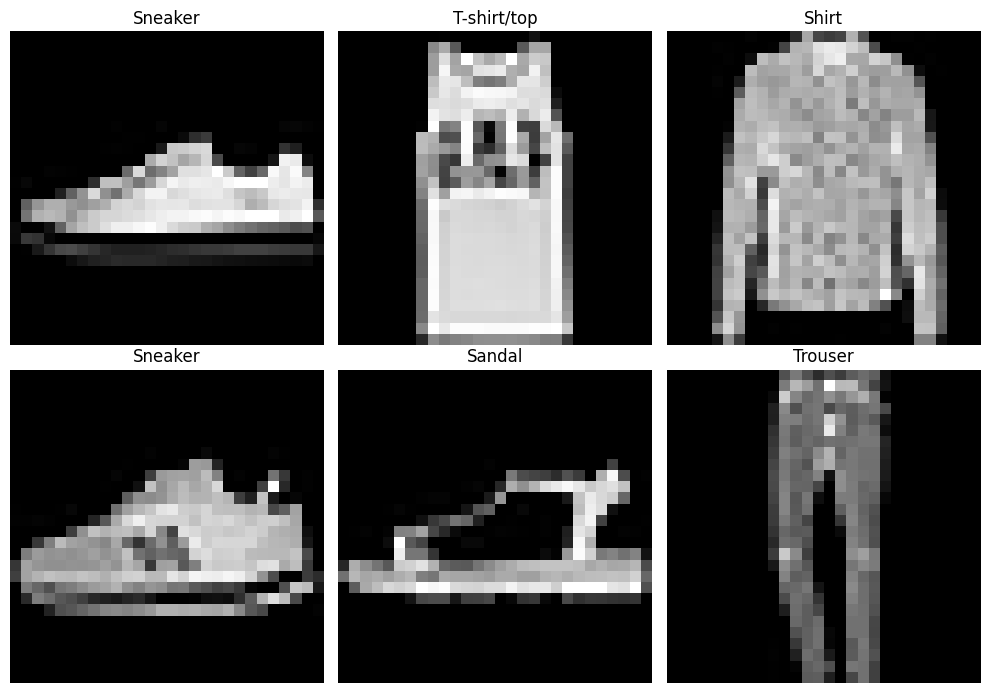

In [125]:
# Define the class labels for Fashion MNIST
classes = (
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
)


# Fetch a batch of 6 images and labels
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Plot the images
fig, axs = plt.subplots(2, 3, figsize=(10, 7))
for i in range(2):
    for j in range(3):
        idx = i * 3 + j
        axs[i, j].imshow(np.squeeze(images[idx].numpy()), cmap="gray")
        axs[i, j].set_title(classes[labels[idx]], fontsize=12)
        axs[i, j].axis("off")

plt.tight_layout()
plt.savefig("FmnistData.pdf")
plt.show()

# FMnist Initial using same parameter as paper


In [ ]:
# Model, loss function, optimizer initialization
model = MyCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

train_and_evaluate_model(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    num_epochs=30,
    name="FMnist_Initial",
)

# Hyper Tuning


In [37]:
# Define hyperparameters to tune
learning_rates = [0.0001, 0.00001, 0.000001]
batch_sizes = [10, 32, 64]
optimizers = [torch.optim.SGD, torch.optim.Adam]
dropout_rates = [0.3, 0.5, 0.6]
kernel_sizes = [3, 4, 5]
num_epochs = 10

best_accuracy = 0.0
best_params = {}

results = {}  # Dictionary to store results

# Counter to keep track of configurations
config_count = 1
total_configs = (
    len(learning_rates)
    * len(batch_sizes)
    * len(optimizers)
    * len(dropout_rates)
    * len(kernel_sizes)
)
# Grid search
for lr in learning_rates:
    for bs in batch_sizes:
        for opt in optimizers:
            for dr in dropout_rates:
                for ks in kernel_sizes:
                    config_key = f"LR: {lr}, BS: {bs}, Optimizer: {opt.__name__}, Dropout: {dr}, Kernel: {ks}"
                    print(f"Configuration {config_count}/{total_configs}:")
                    print(config_key)

                    train_loader = torch.utils.data.DataLoader(
                        train_set, batch_size=bs, shuffle=True
                    )
                    test_loader = torch.utils.data.DataLoader(test_set, batch_size=bs)

                    model = MyCNN(kernel_size=ks, dropout_rate=dr).to(device)
                    criterion = nn.CrossEntropyLoss()
                    optimizer = opt(model.parameters(), lr=lr)

                    # Variables to store cumulative loss across epochs
                    total_train_loss = 0.0
                    total_test_loss = 0.0
                    start_time = time.time()

                    # Train and test the model with the current hyperparameters for the specified number of epochs
                    for epoch in range(num_epochs):
                        train_accuracy, train_loss = train(
                            model, train_loader, criterion, optimizer
                        )
                        total_train_loss += train_loss

                        # Skip further training and testing for this configuration if training accuracy is less than 80%
                        if train_accuracy < 70.0:
                            print(
                                "Train accuracy is less than 70%. Skipping this configuration."
                            )
                            break

                        test_accuracy, test_loss = test(model, test_loader)
                        total_test_loss += test_loss

                        # Printing per-epoch results
                        print(f"Epoch {epoch+1}/{num_epochs}:")
                        print(
                            f"Train Accuracy: {train_accuracy:.2f}% - Train Loss: {train_loss:.4f}"
                        )
                        print(
                            f"Test Accuracy: {test_accuracy:.2f}% - Test Loss: {test_loss:.4f}"
                        )
                        print("----------------------------------------")

                    avg_train_loss = total_train_loss / num_epochs
                    avg_test_loss = total_test_loss / num_epochs
                    end_time = time.time()
                    config_time = end_time - start_time

                    # Store the results ONLY if train_accuracy >= 70%
                    if train_accuracy >= 70.0:
                        results[config_key] = {
                            "Train Accuracy": train_accuracy,
                            "Test Accuracy": test_accuracy,
                            "Average Train Loss": avg_train_loss,
                            "Average Test Loss": avg_test_loss,
                            "Time (in sec)": config_time,
                        }

                    # Update best accuracy and parameters
                    if test_accuracy > best_accuracy:
                        best_accuracy = test_accuracy
                        best_params = {
                            "lr": lr,
                            "batch_size": bs,
                            "optimizer": opt,
                            "dropout_rate": dr,
                            "kernel_size": ks,
                        }
                    print("------------------------------------------------------")
                    config_count += 1

print("Best Test Accuracy:", best_accuracy)
print("Best Hyperparameters:", best_params)

Configuration 1/162:
LR: 0.0001, BS: 10, Optimizer: SGD, Dropout: 0.3, Kernel: 3
256
Train accuracy is less than 70%. Skipping this configuration.
------------------------------------------------------
Configuration 2/162:
LR: 0.0001, BS: 10, Optimizer: SGD, Dropout: 0.3, Kernel: 4
64
Train accuracy is less than 70%. Skipping this configuration.
------------------------------------------------------
Configuration 3/162:
LR: 0.0001, BS: 10, Optimizer: SGD, Dropout: 0.3, Kernel: 5
64
Train accuracy is less than 70%. Skipping this configuration.
------------------------------------------------------
Configuration 4/162:
LR: 0.0001, BS: 10, Optimizer: SGD, Dropout: 0.5, Kernel: 3
256
Train accuracy is less than 70%. Skipping this configuration.
------------------------------------------------------
Configuration 5/162:
LR: 0.0001, BS: 10, Optimizer: SGD, Dropout: 0.5, Kernel: 4
64
Train accuracy is less than 70%. Skipping this configuration.
------------------------------------------------

In [44]:
# Convert the results dictionary to a DataFrame
df_results = pd.DataFrame.from_dict(results, orient="index")

# Save the DataFrame to a CSV file
df_results.to_csv("./data/results.csv")

print("Results saved to 'results.csv'")

Results saved to 'results.csv'


# Optimized MRI Cnn


Configuration 1/1:
LR: 0.0001, BS: 10, Optimizer: Adam, Dropout: 0.3, Kernel: 3
36864


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch [1/30], Train Accuracy: 74.56%, Test Accuracy: 82.84%, Train Loss: 0.7967, Test Loss: 0.7185
Epoch [2/30], Train Accuracy: 84.64%, Test Accuracy: 87.19%, Train Loss: 0.7041, Test Loss: 0.6780
Epoch [3/30], Train Accuracy: 88.43%, Test Accuracy: 89.86%, Train Loss: 0.6656, Test Loss: 0.6545
Epoch [4/30], Train Accuracy: 90.61%, Test Accuracy: 91.73%, Train Loss: 0.6475, Test Loss: 0.6360
Epoch [5/30], Train Accuracy: 92.48%, Test Accuracy: 93.22%, Train Loss: 0.6294, Test Loss: 0.6195
Epoch [6/30], Train Accuracy: 92.79%, Test Accuracy: 93.53%, Train Loss: 0.6241, Test Loss: 0.6144
Epoch [7/30], Train Accuracy: 93.84%, Test Accuracy: 94.53%, Train Loss: 0.6143, Test Loss: 0.6056
Epoch [8/30], Train Accuracy: 94.34%, Test Accuracy: 95.21%, Train Loss: 0.6079, Test Loss: 0.6007
Epoch [9/30], Train Accuracy: 94.22%, Test Accuracy: 93.41%, Train Loss: 0.6079, Test Loss: 0.6191
Epoch [10/30], Train Accuracy: 95.21%, Test Accuracy: 93.16%, Train Loss: 0.6008, Test Loss: 0.6192
Epoch [11

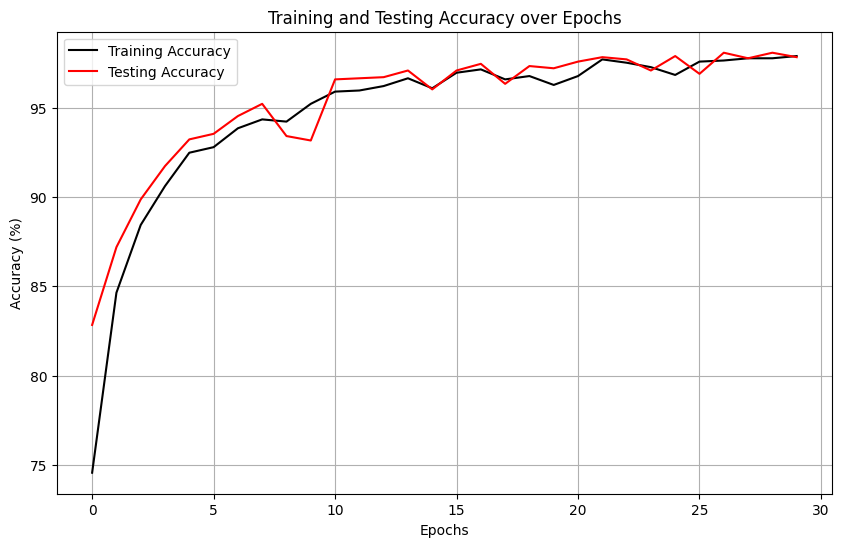

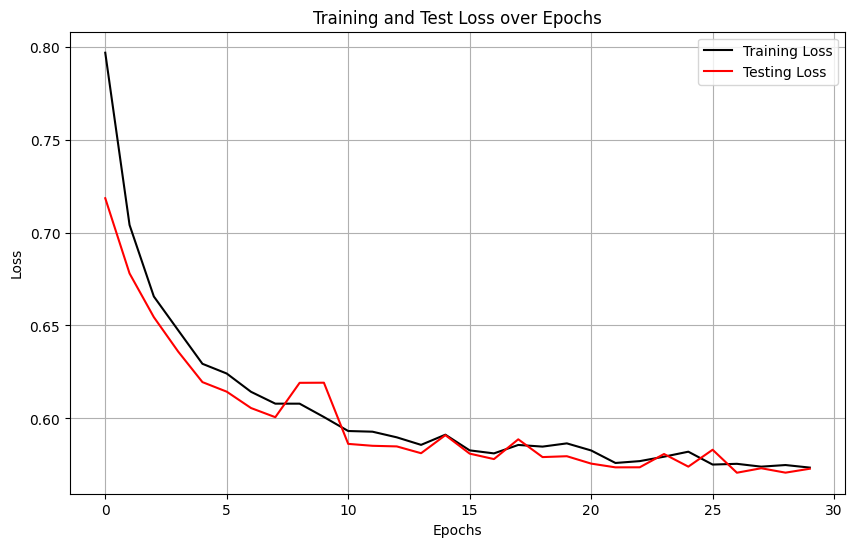

In [46]:
# Define hyperparameters to tune
learning_rates = [0.0001]
batch_sizes = [10]
optimizers = [torch.optim.Adam]
dropout_rates = [0.3]
kernel_sizes = [3]
num_epochs = 30

# Counter to keep track of configurations
config_count = 1
total_configs = (
    len(learning_rates)
    * len(batch_sizes)
    * len(optimizers)
    * len(dropout_rates)
    * len(kernel_sizes)
)
# Grid search
for lr in learning_rates:
    for bs in batch_sizes:
        for opt in optimizers:
            for dr in dropout_rates:
                for ks in kernel_sizes:
                    config_key = f"LR: {lr}, BS: {bs}, Optimizer: {opt.__name__}, Dropout: {dr}, Kernel: {ks}"
                    print(f"Configuration {config_count}/{total_configs}:")
                    print(config_key)

                    train_loader_MRI = torch.utils.data.DataLoader(
                        train_set_MRI, batch_size=bs, shuffle=True
                    )
                    test_loader_MRI = torch.utils.data.DataLoader(
                        train_set_MRI, batch_size=bs
                    )
                    model = MyCNN(
                        kernel_size=ks, dropout_rate=dr, classes=3, input_size=227
                    ).to(device)
                    criterion = nn.CrossEntropyLoss()
                    optimizer = opt(model.parameters(), lr=lr)
                    train_and_evaluate_model(
                        model,
                        train_loader_MRI,
                        test_loader_MRI,
                        criterion,
                        optimizer,
                        num_epochs=30,
                        name="MRI_Optimized",
                    )